# Does You Look Like

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from bing_image_downloader.downloader import download
import face_recognition
from PIL import Image
import pickle
import json
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

''' Главное чтобы все параметры из конфига подтянуть'''

' Главное чтобы все параметры из конфига подтянуть'

In [2]:
# download_pics
target_actors = ['Angelina Jolie', 'Helena Bonham Carter', 'Jennifer Aniston', 'Julia Roberts', 'Kate Beckinsale',
                 'Keira Knightley', 'Lindsey Stirling', 'Marilyn Monroe', 'Monica Bellucci', 'Lucy Liu', 'Scarlett Johansson']

path_to_images_dir = os.path.abspath(os.path.join('E:', 'Python', 'BOT', 'image'))
path_model = os.path.abspath(os.path.join('E:', 'Python', 'BOT', 'model'))
size_new = 256
limit_load_image = 15
random_state = 13
test_size = 0.25
coef_C = 0.8

1 - download_images (+ rename_dir + count_files_in_dir)

2 - reformat_photo

3 - GetEmbedding(get_embedding)

4 - Загрузка данных + обучение модели + тест модели + сохранение модели в pickle

(1-4) выполняются единоразово - для создания обученной модели
 
.

5 - Загрузка фото с поиском лица + загрузка модели + предсказание

6 - Вывод инфы в бота

In [3]:
def download_images(path_download: str, actors: list, limit_load: int=15) -> None:
    '''
    Загрузка изображений указанных актёров/актрис
    
    :param path_download: путь для сохранения изображений на сервере
    :param actors: список актёров/актрис
    :param limit_load: количество изображений для загрузки
    
    :return: None
    '''
    
    # проверка наличия каталогов с изображениями
    # удаление в случае нахождения
    try:
        shutil.rmtree(path_download)
        print('Дерево каталогов удалено')
    except OSError as e:
        print('Error: %s : %s' % (path_download, e.strerror))

    # загрузка изображений из Bing
    for name_actor in tqdm(actors):
        find_string = f'face {name_actor}'
        download(find_string, limit=limit_load,  output_dir=path_download,
                 adult_filter_off=True, force_replace=False, timeout=60, verbose=False)
        
        # переименование каталогов с загруженными изображениями
        rename_dir(path_download, find_string, name_actor)
        
        # подсчёт количества загруженных изображений по каждому запросу
        # с удалением при количестве < 2
        if count_files_in_dir(path_download, name_actor):
            actors.remove(name_actor)

        
def rename_dir(path_dir: str, name_old: str, name_new: str) -> None:
    '''
    Переименование каталога
    
    :param path_dir: путь хранения каталогов
    :param name_old: старое имя каталога
    :param name_new: новое имя каталога
    
    :return: None        
    '''
    
    path_old = os.path.join(path_dir, name_old)
    path_new = os.path.join(path_dir, name_new)
    os.rename(path_old, path_new) 

    
def count_files_in_dir(path_dir: str, name_dir: str) -> bool:
    '''
    Оценка количества файлов в каталогах
    
    :param path_dir: путь хранения каталогов
    :param name_dir: наименование проверяемого каталога
    
    :return: True (if < 2) / False
    :rtype: bool
    '''
    
    path_listdir = os.path.join(path_dir, name_dir)
    files = len(os.listdir(path_listdir))
    if files < 2:
        return True
    return False

In [4]:
def reformat_photo(path_load: str, actors: list, size_new: int) -> None:
    '''
    Изменение размера всех изображений
    :param path_load: путь до каталогов с изображениями
    :param actors: список актёров/актрис
    :param size_new: необходимый размер изображения по одной из сторон
    
    :return: None
    '''
    
    for name in actors:
        path_to_images = os.path.join(path_load, name)
        images = os.listdir(path_to_images)
        for img in images:
            path_image = os.path.join(path_to_images, img)
            # изменение формата изображения и сохранения под тем же именем
            with Image.open(path_image) as photo:
                photo_resized = resize_photo(photo, size_new)
                photo_resized_conv = photo_resized.convert('RGB')
                photo_resized_conv.save(path_image)
                
def resize_photo(image: Image, size_new: int) -> Image:
    '''
    Изменение размера изображения
    :param image: исходное изображение
    :param size_new: необходимый размер изображения по одной из сторон
    
    :return: финальное изображение
    :rtype: Image
    '''
    
    # получение размера исходного изображения
    size = image.size
    
    # рассчёт коэффициента по одной из сторон
    coef = size_new / size[0]
    first_side = int(size[0] * coef)
    second_side = int(size[1] * coef)
    
    # изменение размера изображения
    resized_image = image.resize((first_side, second_side))
    resized_image = resized_image.convert('RGB')
    return resized_image

In [5]:
class GetEmbedding:
    '''
    Поиск лиц на фотографиях, и сохранение полученных эмбедингов в pickle
    
    
    Args:
        actors (list): список актёров/актрис 
        path_load (str): путь до каталогов с изображениями
        path_save (str): путь сохранения эмбеддингов и таргетов
        
    '''
    
    def __init__(self, actors: list, path_load: str, path_save: str):
        self.actors = actors
        self.path_load = path_load
        self.path_save = path_save
        
    def get_save_embedding(self) -> None:
        ''' Получение эмбеддингов, таргетов, имён с индексами, и сохранение в файлы '''
        
        embeddings, targets, name_labels = self.__create_embedding()
        
        path_emb = os.path.join(self.path_save, 'embeddings.pkl')
        with open(path_emb, 'wb') as f:
            pickle.dump(embeddings, f)
        
        path_tar = os.path.join(self.path_save, 'targets.pkl')
        with open(path_tar, 'wb') as f:
            pickle.dump(targets, f)
            
        path_act = os.path.join(self.path_save, 'name_labels.json')
        json_act = json.dumps(name_labels, indent=4)
        with open(path_act, 'w') as f:
            f.write(json_act)
        
    def __create_embedding(self) -> tuple[np.array, list, dict]:
        '''
        Поиск лиц,
        и формирование эмбеддингов, таргетов и словаря имена:таргеты

        :return: эмбеддинги, таргеты, словарь имена:таргеты
        :rtype: tuple[np.array, list, dict]
        '''
        
        embeddings = np.empty(128)
        targets = []
        name_labels = self.__create_labels()
        for name in self.actors:
            path_to_images = os.path.join(self.path_load, name)
            images_for_name = os.listdir(path_to_images)
            for img in images_for_name:
                try:
                    path_image = os.path.join(path_to_images, img)
                    face = face_recognition.load_image_file(path_image)
                    
                    face_boxes = face_recognition.face_locations(face)
                    # если найдено больше 1 лица на изображении - оно исключается
                    if len(face_boxes) != 1:
                        continue
                        
                    try:
                        face_encod = face_recognition.face_encodings(face)[0]
                        embeddings = np.vstack((embeddings, face_encod))
                        # добавление таргета по имени
                        targets.append(name_labels[name])
                    except Exception as ex:
                        print(f'Error: {ex}')
                    
                except Exception as ex:
                    print(f'Error: {ex}')
                    
        return embeddings[1:], targets, name_labels
                    
    def __create_labels(self) -> dict:
        ''' Создание словаря имена:таргеты '''
        
        name_labels = dict()
        for label, name in enumerate(self.actors):
            name_labels[name] = label
        return name_labels

In [6]:
#!!! Универсальность функции по доставанию лица с изображения
# чтобы использовать для соло фотографии

In [51]:
class ModelImgLR:
    '''
    Модель логистической регрессии
    
    
    Args:
        path_load (str): путь до каталога с эмбеддингами и таргетами
        random_state (int): параметр random_state
        test_size (float): параметр test_size для train_test_split
        coef_C (float): параметр C для логистической регрессии
    '''
    
    def __init__(self, path_load:str, random_state: int=0, test_size: float=0.3, coef_C: float = 1.0):
        self.path_load = path_load
        self.test_size = test_size
        self.random_state = random_state
        self.coef_C = coef_C
        
        # загрузка эмбеддингов и таргетов
        self.embeddings, self.targets = self.__load_data()

    def fit_model(self) -> LogisticRegression:
        ''' 
        Обучение модели, 
        сохранение в pickle, в каталог с эмбеддингами и таргетами

        :return: модель машинного обучения, тестовые данные X_test и y_test
        :rtype: LogisticRegression, np.array, np.array

        '''
        
        min_num_target, name_min_target = self.__check_min_target()
        if min_num_target > 1:
            X_train, X_test, y_train, y_test = train_test_split(self.embeddings, self.targets, 
                                                                test_size=self.test_size, 
                                                                random_state=self.random_state,
                                                                stratify=self.targets)
            model_LR = LogisticRegression(random_state=self.random_state, C = self.coef_C)
            model_LR.fit(X_train, y_train)
            
            self.__save_model(model_LR)
            
            return model_LR, X_test, y_test
        else:
            #logging.info(f'Problem with data. Target: {name_min_target}')
            print(f'Problem with data. Target: {name_min_target}')
    
    def __load_data(self) -> tuple[np.array, list]:
        ''' Загрузка данных для обучения '''
        
        try:
            path_embeddings = os.path.join(self.path_load, 'embeddings.pkl')
            with open(path_embeddings, 'rb') as file:
                load_embeddings = pickle.load(file)

            path_targets = os.path.join(self.path_load, 'targets.pkl')
            with open(path_targets, 'rb') as file:
                load_targets = pickle.load(file)
        except Exception as ex:
                        print(f'Error: {ex}')
        else:
            return load_embeddings, load_targets
        
    def __check_min_target(self) -> tuple[int, str]:
        ''' Подсчёт количества каждой из меток в списке, с нахождением минимального '''

        targets_counter = Counter(self.targets)
        min_num_target = np.inf
        name_min_target = ''
        for target in targets_counter.keys():
            if targets_counter[target] < min_num_target:
                min_num_target = targets_counter[target]
                name_min_target = target

        return min_num_target, str(name_min_target)
    
    def __save_model(self, model_LR: LogisticRegression) -> None:
        ''' Сохранение модели логистической регрессии в файл '''
        
        path_save = os.path.join(self.path_load, 'model_LR.pkl')
        with open(path_save, 'wb') as f:
            pickle.dump(model_LR, f)
        

    # ну и запуск всего добра
    #__name__ == __main__:
''' запуск всего скрипта на обучение, файлы до этого не запускаются сами '''
''' С проверкой на необходимость закачки и предобработки данных! '''

' С проверкой на необходимость закачки и предобработки данных! '

In [31]:
# download_images(path_to_images_dir, target_actors, limit_load_image)

Дерево каталогов удалено


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

[%] Downloading Images to E:\Python\BOT\image\face Angelina Jolie
[!] Issue getting: https://s.yimg.com/ny/api/res/1.2/IxNuyItRgvBgVSspytvmOg--~A/YXBwaWQ9aGlnaGxhbmRlcjtzbT0xO3c9ODAw/http://media.zenfs.com/en-US/homerun/hello_giggles_454/6b982e94b82db4201dce770c9fe6592f
[!] Error:: HTTP Error 401: Unauthorized


  9%|███████▌                                                                           | 1/11 [00:17<02:52, 17.25s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Helena Bonham Carter


 18%|███████████████                                                                    | 2/11 [00:26<01:54, 12.74s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Jennifer Aniston
[Error]Invalid image, not saving http://images3.wikia.nocookie.net/__cb20120521155228/doblajesanimados/es/images/f/f9/Jennifer_Aniston.jpg

[!] Issue getting: http://images3.wikia.nocookie.net/__cb20120521155228/doblajesanimados/es/images/f/f9/Jennifer_Aniston.jpg
[!] Error:: Invalid image, not saving http://images3.wikia.nocookie.net/__cb20120521155228/doblajesanimados/es/images/f/f9/Jennifer_Aniston.jpg

[!] Issue getting: https://www.myconfinedspace.com/wp-content/uploads/tdomf/136776/JenniferAnistonIndeximage.jpg
[!] Error:: <urlopen error [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера>


 27%|██████████████████████▋                                                            | 3/11 [01:01<03:02, 22.77s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Julia Roberts
[!] Issue getting: https://celebsheight.org/actors/8-Julia Roberts.jpg
[!] Error:: URL can't contain control characters. '/actors/8-Julia Roberts.jpg' (found at least ' ')
[!] Issue getting: https://i1.wp.com/incosmetics.wordpress.com/files/2009/12/julia-roberts-lancome1.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: http://www.hdnicewallpapers.com/Walls/Big/Julia Roberts/Beautiful_Face_of_Julia_Roberts.jpg
[!] Error:: URL can't contain control characters. '/Walls/Big/Julia Roberts/Beautiful_Face_of_Julia_Roberts.jpg' (found at least ' ')
[!] Issue getting: https://www.hdnicewallpapers.com/Walls/Big/Julia Roberts/Beautiful_Face_Julia_Roberts.jpg
[!] Error:: URL can't contain control characters. '/Walls/Big/Julia Roberts/Beautiful_Face_Julia_Roberts.jpg' (found at least ' ')
[Error]Invalid image, not saving https://i.dailymail.co.uk/i/pix/2013/10/23/article-0-18E2418300000578

 36%|██████████████████████████████▏                                                    | 4/11 [01:25<02:42, 23.16s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Kate Beckinsale
[Error]Invalid image, not saving http://www.vidigy.com/wp-content/uploads/2012/04/Kate-Beckinsale_0412-1.jpg

[!] Issue getting: http://www.vidigy.com/wp-content/uploads/2012/04/Kate-Beckinsale_0412-1.jpg
[!] Error:: Invalid image, not saving http://www.vidigy.com/wp-content/uploads/2012/04/Kate-Beckinsale_0412-1.jpg



 45%|█████████████████████████████████████▋                                             | 5/11 [01:41<02:04, 20.68s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Keira Knightley
[!] Issue getting: https://external-preview.redd.it/4EkLDTKR_tQ1P9fy_5dwnpjlh0_maITfIugSD7O2laM.jpg?auto=webp&amp;s=83d773e9e9753f6d15df103e072b20029a053eef
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://static3.businessinsider.com/image/5ab95d6442e1cc20fa25a8b6-2005/keira knightley attends the atonement photocall during day 1 of the 64th annual venice film festival on august 29 2007 in venice italy.jpg
[!] Error:: URL can't contain control characters. '/image/5ab95d6442e1cc20fa25a8b6-2005/keira knightley attends the atonement photocall during day 1 of the 64th annual venice film festival on august 29 2007 in venice italy.jpg' (found at least ' ')
[Error]Invalid image, not saving http://sizzlingsuperstars.com/wp-content/uploads/2016/07/Keira-Knightley-10.jpg

[!] Issue getting: http://sizzlingsuperstars.com/wp-content/uploads/2016/07/Keira-Knightley-10.jpg
[!] Error:: 

 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:52<01:27, 17.44s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Lindsey Stirling


 64%|████████████████████████████████████████████████████▊                              | 7/11 [02:11<01:11, 17.90s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Marilyn Monroe
[!] Issue getting: http://www.celeb-face.com/albums/celebrities/u/9/Marilyn-Monroe/Marilyn-Monroe-479.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: https://i1.wp.com/fronkonstin.com/wp-content/uploads/2014/02/marilyn-monroe3.jpg
[!] Error:: HTTP Error 404: Not Found
[Error]Invalid image, not saving http://i.dailymail.co.uk/i/pix/2015/01/05/007498A200000258-0-image-a-40_1420436941542.jpg

[!] Issue getting: http://i.dailymail.co.uk/i/pix/2015/01/05/007498A200000258-0-image-a-40_1420436941542.jpg
[!] Error:: Invalid image, not saving http://i.dailymail.co.uk/i/pix/2015/01/05/007498A200000258-0-image-a-40_1420436941542.jpg



 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [02:28<00:53, 17.73s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Monica Bellucci


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [02:38<00:30, 15.22s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Lucy Liu
[!] Issue getting: https://image.tmdb.org/t/p/original/1leItxMN9yxvySPNpJJqQFUFUT9.jpg
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: http://image.tmdb.org/t/p/original/dW6JDvYhXWW87P04W2SfNpiAwCO.jpg
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: http://media1.popsugar-assets.com/files/2012/11/45/5/192/1922153/7bd9dbc672fa0f19_155854280/i/Lucy-Liu.jpg
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: http://www.graphis.com/media/uploads/cfe/entry/ab5a6d12-08a3-4334-8b1f-d3d2542aa305/120116_LATIMES_LUCY-Liu164.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)>


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:50<00:14, 14.32s/it]



[%] Done. Downloaded 15 images.
[%] Downloading Images to E:\Python\BOT\image\face Scarlett Johansson
[!] Issue getting: https://cdn.wallpapersafari.com/44/57/proNjB.jpg
[!] Error:: <urlopen error [Errno 2] No such file or directory>
[!] Issue getting: https://images6.alphacoders.com/405/thumb-1920-405788.jpg
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://images7.alphacoders.com/362/362419.jpg
[!] Error:: HTTP Error 403: Forbidden


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:08<00:00, 17.17s/it]



[%] Done. Downloaded 15 images.


In [15]:
# reformat_photo(path_to_images_dir, target_actors, size_new)
# actors_embedding = GetEmbedding(target_actors, path_to_images_dir, path_model)
# actors_embedding.get_save_embedding()

In [53]:
#MyModel = ModelImgLR(path_model, random_state, test_size, coef_C)
MyModel = ModelImgLR(path_model, random_state, test_size)
model_LR, X_test, y_test = MyModel.fit_model()
f1_model_score = f1_score(y_test, model_LR.predict(X_test), average='micro')
print(f'F1 score: {f1_model_score}')

F1 score: 1.0


In [32]:
class PredictModelImgLR:
    '''
    Предсказание на модели логистической регрессии по тестовому изображению
    
    
    Args:
        path_load (str): путь до каталога с тестовым изображением
        size_new (int): необходимый размер изображения по одной из сторон
    '''
    
    def __init__(self, path_load:str, size_new:int):
        self.path_load = path_load
        self.size_new = size_new
        
        # загрузка модели, словаря имён:таргетов
        self.model, self.name_labels = self.__load_data()

    def predict_model(self) -> None:
        ''' Предсказание на модели логистической регрессии '''
        
        test_photo_resized_conv = self.__load_image()
        
        test_face_boxes = face_recognition.face_locations(test_photo_resized_conv)
        # если найдено больше 1 лица на изображении - оно исключается
        if len(test_face_boxes) == 1:
            test_face_encod = face_recognition.face_encodings(test_photo_resized_conv)[0]
            test_predict = self.model.predict([test_face_encod])
            test_predict_name = list(self.name_labels.keys())[list(self.name_labels.values()).index(test_predict)]
            print('predict: %d' % test_predict)
            print('predict name: %s' % test_predict_name)
            
            
            test_predict_proba = self.model.predict_proba([test_face_encod])[0][test_predict][0]
            print(test_predict_proba)
            
    
    def __load_data(self) -> tuple[np.array, dict]:
        ''' Загрузка данных для обучения '''
        
        try:
            path_model = os.path.join(self.path_load, 'model_LR.pkl')
            with open(path_model, 'rb') as file:
                load_model = pickle.load(file)

            path_act = os.path.join(self.path_load, 'name_labels.json')
            with open(path_act, 'r') as file:
                load_name_labels = json.load(file)
        except Exception as ex:
                        print(f'Error: {ex}')
        else:
            return load_model, load_name_labels
        
    def __load_image(self) -> np.array(Image):
        ''' Загрузка изображения, с изменением размера '''
        
        path_test_image = os.path.join(self.path_load, 'test_image.jpg')
        # изменение формата тестового изображения
        with Image.open(path_test_image) as photo:
            test_photo_resized = resize_photo(photo, self.size_new)
            test_photo_resized_conv = np.array(test_photo_resized.convert('RGB'))
        
        return test_photo_resized_conv

In [54]:
predict_model_img_lr = PredictModelImgLR(path_model, size_new)
predict_model_img_lr.predict_model()

predict: 1
predict name: Helena Bonham Carter
0.1387612180102584


In [50]:
d = {'col1': [1, 2, 3], 'col2': [4, 5, 6]}
df = pd.DataFrame(d)
print(df[:2].to_string(index=False))

 col1  col2
    1     4
    2     5


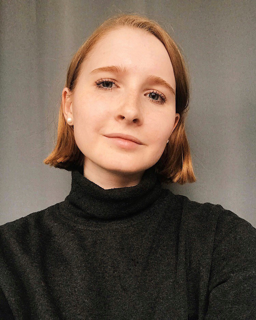

In [19]:
path_test_image = os.path.join(path_model, 'test_image.jpg')
# изменение формата тестового изображения
with Image.open(path_test_image) as photo:
    test_photo_resized = resize_photo(photo, size_new)
    test_photo_resized_conv = test_photo_resized.convert('RGB')
test_photo_resized_conv

In [21]:
face_recognition.face_locations(test_photo_resized_conv)


TypeError: __call__(): incompatible function arguments. The following argument types are supported:
    1. (self: _dlib_pybind11.fhog_object_detector, image: array, upsample_num_times: int=0) -> _dlib_pybind11.rectangles

Invoked with: <_dlib_pybind11.fhog_object_detector object at 0x0000015993F8E370>, <PIL.Image.Image image mode=RGB size=256x320 at 0x1599F543700>, 1

In [40]:
aaa = [0.24224, 0.15151, 0.67587]
list(map(lambda x: round(x*100, 1), aaa))

[24.2, 15.2, 67.6]

In [ ]:
# для имен-таргетов для вывода предсказаний
path_act = os.path.join(self.path_load, os.path.sep, 'name_labels.json')
with open(path_act, 'r') as file:
    load_name_labels = json.load(file)
            

In [ ]:
base_random_state = 13
base_test_size = 0.3

y_data = data['Churn'].values
X_data = data.drop('Churn', axis=1).values
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X_data, y_data, 
                                                                        test_size=base_test_size, 
                                                                        random_state=base_random_state)
# параметры мета-алгоритма
lr_params = {'C': np.arange(0.5, 1, 0.1)} # LogisticRegression
# параметры валидации
base_cv = 5
skf_params = StratifiedKFold(n_splits=5, random_state=base_random_state, shuffle=True)
my_n_jobs = multiprocessing.cpu_count() - 2

# функция для вычисления ниболее подходящих параметров для моделей
def top_gs(model, params, X_train_gs, y_train_gs, cv_or_skf):
    tmp_gs_model = GridSearchCV(estimator=model, param_grid=params, cv=cv_or_skf, scoring='roc_auc')
    tmp_gs_model.fit(X_train_gs, y_train_gs)
    print('Best params for {name}: {params}\n'.format(name=model.__class__.__name__, 
                                                    params=tmp_gs_model.best_params_))    
    
# инициализация мета-алгоритма
lr = LogisticRegression(random_state=base_random_state)

lr_2 = LogisticRegression(random_state=base_random_state)
top_gs(lr_2, lr_params, X_train_main, y_train_main, skf_params)
lr_2.set_params(C = 0.9)
lr_2.fit(X_train_main, y_train_main)

# Получение прогнозов по отложенной выборке 
lr_2_test_predict = lr_2.predict(X_test_main)
lr_2_test_predict_proba = lr_2.predict_proba(X_test_main)

lr_2_recall = recall_score(y_test_main, lr_2_test_predict)
print('Recall score для lr_2: {score} '.format(score=lr_2_recall))

lr_2_roc_auc = roc_auc_score(y_test, lr_2_test_predict_proba[:, 1])
print('Roc_Auc score для lr_2: {score}'.format(score=lr_2_roc_auc))

In [ ]:
face = face_recognition.load_image_file(f'{path_to_images}/{person}/Image_1.jpg')
face_boxes = face_recognition.face_locations(face)

In [ ]:
face_enc = face_recognition.face_encodings(face)

In [ ]:
embeddings = np.empty(128)
embeddings = np.vstack((embedings, face_enc))

In [ ]:
with open (f'{path_to_images}/{person}/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [ ]:
os.listdir(f'{path_to_images}/{person}')

In [ ]:
#--------------------------------------------------------------------------------------------------------------------#

In [7]:
path_image = os.path.join(path_to_images, 'face Helena Bonham Carter')
with Image.open(os.path.join(path_image, 'Image_1.jpg')) as img:
    newImRes = resize_photo(img, 256)
    newImRes

In [12]:
type(newImRes)

PIL.Image.Image

In [55]:
img_resized.show()

In [67]:
new_img = Image.new("RGBA", img_resized.size)
new_img = new_img.paste(img_resized)
new_img

In [114]:
img_resized = mpimg.imread(os.path.join(path_image, 'Image_1.jpg'))

In [121]:
def rgb2gray(rgb):
    ''' Берётся среднее трёх цветов RGB'''
    tile = np.tile(np.c_[0.5, 0.5, 0.5], reps=(rgb.shape[0],rgb.shape[1],1))
    #print((tile*rgb)[:3])
    return np.sum(tile * rgb, axis=2)

In [122]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

img_gray = rgb2gray(img_resized)
print(type(img_gray), img_gray.shape)
imshow(img_gray, cmap = "gray")
plt.show()

ValueError: operands could not be broadcast together with shapes (2048,2048,3) (2048,2048) 

In [49]:
img_resized.convert('RGB').save(os.path.join(path_image, 'Image_1_resized_convert.jpg'))

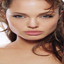

In [6]:
import glob
path_to_images = os.path.abspath(os.path.join('E:', os.path.sep, 'image'))
person = 'face Angelina Jolie'
len(glob.glob(f'{path_to_images}/{person}/*'))

11

In [22]:
glob.glob(f'{path_to_images}/{person}/*')

['E:\\image/face Angelina Jolie\\Image_1.jpg',
 'E:\\image/face Angelina Jolie\\Image_10.jpg',
 'E:\\image/face Angelina Jolie\\Image_1_resized.jpg',
 'E:\\image/face Angelina Jolie\\Image_2.jpg',
 'E:\\image/face Angelina Jolie\\Image_3.JPG',
 'E:\\image/face Angelina Jolie\\Image_4.jpg',
 'E:\\image/face Angelina Jolie\\Image_5.jpg',
 'E:\\image/face Angelina Jolie\\Image_6.jpg',
 'E:\\image/face Angelina Jolie\\Image_7.jpg',
 'E:\\image/face Angelina Jolie\\Image_8.jpg',
 'E:\\image/face Angelina Jolie\\Image_9.jpg']

In [7]:
os.listdir(f'{path_to_images}/{person}')

['Image_1.jpg',
 'Image_10.jpg',
 'Image_1_resized.jpg',
 'Image_2.jpg',
 'Image_3.JPG',
 'Image_4.jpg',
 'Image_5.jpg',
 'Image_6.jpg',
 'Image_7.jpg',
 'Image_8.jpg',
 'Image_9.jpg']

In [8]:
face = face_recognition.load_image_file(f'{path_to_images}/{person}/Image_1.jpg')
face_boxes = face_recognition.face_locations(face)

In [9]:
face_boxes

[(298, 1043, 1256, 85)]

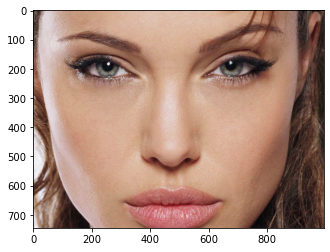

In [10]:
from matplotlib.pyplot import imshow
cropped = face[298:1043, 85:1256]
imshow(cropped)

In [20]:
face_enc = face_recognition.face_encodings(face)[0]

In [21]:
face_enc

array([-0.12147723,  0.11791576,  0.21875428, -0.07975225, -0.11812846,
       -0.0398988 , -0.05937986, -0.13103133,  0.17880462, -0.11699323,
        0.19326422, -0.04938241, -0.35984007,  0.04525584, -0.05929466,
        0.16341585, -0.13712722, -0.20814212, -0.06984105, -0.06026541,
        0.05838125, -0.00338435, -0.05784539,  0.07802898, -0.16128778,
       -0.35597974, -0.08707687,  0.02547696, -0.10665647, -0.1603146 ,
        0.04861875,  0.11466263, -0.2248753 ,  0.03327718, -0.07225315,
        0.18152286, -0.01954834, -0.21204171,  0.04086827,  0.06648828,
       -0.27162477, -0.10915212,  0.06318666,  0.25316218,  0.2110514 ,
       -0.05138711,  0.0846943 , -0.04458064,  0.09397285, -0.2864913 ,
       -0.00808341,  0.21525773,  0.04028871,  0.09671867,  0.07985184,
       -0.27318335,  0.06409194,  0.05681464, -0.11719589,  0.01551921,
        0.12503488, -0.13339764,  0.04402679, -0.05606855,  0.18208599,
        0.0887375 , -0.14268818, -0.08157942,  0.19601478, -0.13

In [13]:
len(face_enc)

1

In [18]:
embedings = np.empty(128)
embedings = np.vstack((embedings, face_enc[0]))

In [19]:
embedings

array([[ 1.02576354e-311,  1.02576485e-311,  1.02583077e-311,
         1.02576488e-311,  1.02582554e-311,  1.02582584e-311,
         1.02582528e-311,  1.02582465e-311,  1.02576471e-311,
         1.02582565e-311,  1.02582534e-311,  1.02582534e-311,
         1.02582535e-311,  1.02582538e-311,  1.02582538e-311,
         1.02576407e-311,  1.02582520e-311,  1.02582536e-311,
         1.02582535e-311,  1.02582535e-311,  1.02582557e-311,
         1.02582553e-311,  1.02582540e-311,  1.02582555e-311,
         1.02576500e-311,  1.02582563e-311,  1.02582563e-311,
         1.02582528e-311,  1.02582935e-311,  1.02582564e-311,
         1.02582529e-311,  1.02582529e-311,  1.02582529e-311,
         1.02582529e-311,  1.02582556e-311,  1.02582937e-311,
         1.02582501e-311,  1.02582501e-311,  1.02582498e-311,
         1.02583076e-311,  1.02582502e-311,  1.02582502e-311,
         1.02582502e-311,  1.02582538e-311,  1.02582538e-311,
         1.02582538e-311,  1.02582529e-311,  1.02582529e-311,
        

In [ ]:
with open (f'{path_to_images}/{person}/embedings.pkl', 'wb') as f:
    pickle.dump(embedings, f)

In [ ]:
os.listdir('E:\\image/Angelina Jolie')

In [ ]:
with open (f'{path_to_images}/{person}/embedings.pkl', 'rb') as f:
    new_embedings = pickle.load(f)
new_embedings